In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428190859/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [2]:
img, label=mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


In [3]:
def denorm(x):
    out=(x+1)/2
    return out.clamp(0,1)



Label: 5


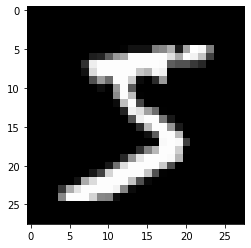

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([4, 3, 7, 4, 7, 0, 2, 4, 1, 2, 8, 2, 3, 6, 1, 7, 3, 0, 7, 0, 8, 5, 8, 1,
        5, 5, 1, 6, 7, 4, 4, 0, 4, 8, 6, 1, 0, 3, 5, 9, 8, 7, 2, 3, 4, 9, 9, 2,
        2, 7, 5, 1, 0, 6, 5, 2, 5, 6, 6, 3, 4, 8, 2, 1, 5, 7, 9, 0, 8, 5, 7, 9,
        1, 1, 2, 7, 2, 5, 0, 8, 1, 7, 6, 1, 4, 4, 8, 5, 5, 7, 3, 3, 2, 1, 0, 2,
        0, 8, 7, 8])


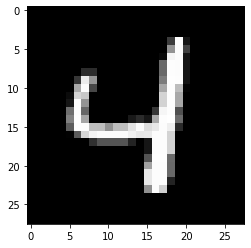

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
image_size=784
hidden_size=256

In [9]:
import torch.nn as nn

D=nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [10]:
D.to(device);


In [11]:
latent_size=64

In [12]:
G=nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(0.2),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [13]:
G.to(device);


In [14]:
criterion=nn.BCELoss()
d_optimizer=torch.optim.Adam(D.parameters(), lr=0.0002)

In [15]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


In [16]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
def train_discriminator(images):
    real_labels=torch.ones(batch_size, 1).to(device)
    fake_labels=torch.zeros(batch_size, 1).to(device)
    
    outputs=D(images)
    d_loss_real=criterion(outputs, real_labels)
    real_score=outputs
    
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    d_loss=d_loss_real+d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score


In [17]:
def train_generator():
    img=torch.randn(batch_size, latent_size).to(device)
    fake_images=G(img)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)
    
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [18]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

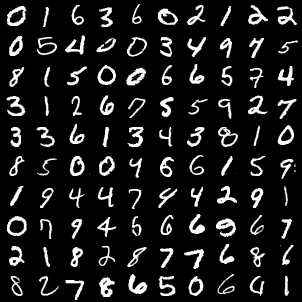

In [19]:
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


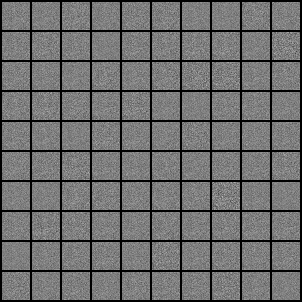

In [20]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [21]:
%%time

num_epochs=300
total_step=len(data_loader)
d_losses, g_losses, real_scores, fake_scores=[], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images=images.reshape(batch_size, -1).to(device)
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
            
        
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0840, g_loss: 3.9087, D(x): 0.98, D(G(z)): 0.06
Epoch [0/300], Step [400/600], d_loss: 0.2950, g_loss: 4.9811, D(x): 0.91, D(G(z)): 0.09
Epoch [0/300], Step [600/600], d_loss: 0.1471, g_loss: 4.1296, D(x): 0.94, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1931, g_loss: 4.0498, D(x): 0.95, D(G(z)): 0.10
Epoch [1/300], Step [400/600], d_loss: 0.2519, g_loss: 4.0913, D(x): 0.96, D(G(z)): 0.17
Epoch [1/300], Step [600/600], d_loss: 0.3141, g_loss: 4.0672, D(x): 0.90, D(G(z)): 0.07
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.4434, g_loss: 2.6335, D(x): 0.92, D(G(z)): 0.26
Epoch [2/300], Step [400/600], d_loss: 0.1037, g_loss: 4.6600, D(x): 0.94, D(G(z)): 0.03
Epoch [2/300], Step [600/600], d_loss: 0.4432, g_loss: 4.0891, D(x): 0.87, D(G(z)): 0.13
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.5886, g_loss: 1.6819, D(x): 0.52, D(G(z)): 0.16
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.2765, g_loss: 3.9652, D(x): 0.97, D(G(z)): 0.18
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.4663, g_loss: 3.4277, D(x): 0.85, D(G(z)): 0.10
Epoch [28/300], Step [400/600], d_loss: 0.3721, g_loss: 3.8693, D(x): 0.91, D(G(z)): 0.15
Epoch [28/300], Step [600/600], d_loss: 0.4666, g_loss: 4.9872, D(x): 0.87, D(G(z)): 0.12
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.2731, g_loss: 4.1548, D(x): 0.93, D(G(z)): 0.10
Epoch [29/300], Step [400/600], d_loss: 0.6958, g_loss: 2.7560, D(x): 0.80, D(G(z)): 0.08
Epoch [29/300], Step [600/600], d_loss: 0.4024, g_loss: 2.9415, D(x): 0.87, D(G(z)): 0.11
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.3458, g_loss: 3.9545, D(x): 0.95, D(G(z)): 0.18
Epoch [30/300], Step [400/600], d_loss: 0.4163, g_loss: 3.5709, D(x): 0.92, D(G(z)): 0.18
Epoch [30/300], Step [600/600], d_loss: 0.4877, g_loss: 4.7480, D(x): 0.83, D(G(z)): 0.07
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.7151, g_loss: 2.1778, D(x): 0.74, D(G(z)): 0.20
Epoch [55/300], Step [600/600], d_loss: 0.5715, g_loss: 2.4221, D(x): 0.80, D(G(z)): 0.18
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.5440, g_loss: 2.6534, D(x): 0.83, D(G(z)): 0.19
Epoch [56/300], Step [400/600], d_loss: 0.6203, g_loss: 2.5214, D(x): 0.78, D(G(z)): 0.16
Epoch [56/300], Step [600/600], d_loss: 0.4534, g_loss: 2.2042, D(x): 0.83, D(G(z)): 0.15
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.6791, g_loss: 2.2309, D(x): 0.76, D(G(z)): 0.22
Epoch [57/300], Step [400/600], d_loss: 0.7005, g_loss: 2.1902, D(x): 0.81, D(G(z)): 0.29
Epoch [57/300], Step [600/600], d_loss: 0.5700, g_loss: 2.3518, D(x): 0.81, D(G(z)): 0.17
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6164, g_loss: 2.0394, D(x): 0.85, D(G(z)): 0.29
Epoch [58/300], Step [400/600], d_loss: 0.4836, g_loss: 2.4821, D(x): 0.86, D(G(z)): 0.19
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.7214, g_loss: 1.6658, D(x): 0.73, D(G(z)): 0.21
Epoch [83/300], Step [400/600], d_loss: 0.7706, g_loss: 2.3160, D(x): 0.74, D(G(z)): 0.22
Epoch [83/300], Step [600/600], d_loss: 0.8791, g_loss: 1.5715, D(x): 0.75, D(G(z)): 0.31
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.8304, g_loss: 1.8592, D(x): 0.78, D(G(z)): 0.29
Epoch [84/300], Step [400/600], d_loss: 0.7242, g_loss: 1.8463, D(x): 0.83, D(G(z)): 0.29
Epoch [84/300], Step [600/600], d_loss: 0.6732, g_loss: 2.2529, D(x): 0.80, D(G(z)): 0.25
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.7306, g_loss: 2.5552, D(x): 0.69, D(G(z)): 0.12
Epoch [85/300], Step [400/600], d_loss: 0.8766, g_loss: 2.0990, D(x): 0.83, D(G(z)): 0.34
Epoch [85/300], Step [600/600], d_loss: 0.8671, g_loss: 2.2953, D(x): 0.67, D(G(z)): 0.19
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.9820, g_loss: 1.9633, D(x): 0.68, D(G(z)): 0.26
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.9119, g_loss: 1.4230, D(x): 0.74, D(G(z)): 0.34
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.8528, g_loss: 1.8601, D(x): 0.77, D(G(z)): 0.31
Epoch [111/300], Step [400/600], d_loss: 0.7367, g_loss: 1.8572, D(x): 0.70, D(G(z)): 0.20
Epoch [111/300], Step [600/600], d_loss: 0.7413, g_loss: 1.9826, D(x): 0.75, D(G(z)): 0.25
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.9258, g_loss: 1.6586, D(x): 0.63, D(G(z)): 0.23
Epoch [112/300], Step [400/600], d_loss: 0.8810, g_loss: 1.6347, D(x): 0.75, D(G(z)): 0.34
Epoch [112/300], Step [600/600], d_loss: 0.9932, g_loss: 1.5173, D(x): 0.74, D(G(z)): 0.35
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.7714, g_loss: 1.9511, D(x): 0.74, D(G(z)): 0.27
Epoch [113/300], Step [400/600], d_loss: 0.8188, g_loss: 1.8889, D(x): 0.77, D(G(z)): 0.33
Epoch [113/300], Step [600/600], d_loss: 0.8082, g_loss: 1.8995, D(x): 0.72, D(G(z)): 0.25
Saving

Epoch [138/300], Step [200/600], d_loss: 0.8069, g_loss: 2.3470, D(x): 0.72, D(G(z)): 0.26
Epoch [138/300], Step [400/600], d_loss: 0.9838, g_loss: 1.5946, D(x): 0.62, D(G(z)): 0.28
Epoch [138/300], Step [600/600], d_loss: 0.7973, g_loss: 1.7967, D(x): 0.75, D(G(z)): 0.27
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.7847, g_loss: 1.7813, D(x): 0.69, D(G(z)): 0.22
Epoch [139/300], Step [400/600], d_loss: 0.8029, g_loss: 2.2373, D(x): 0.73, D(G(z)): 0.25
Epoch [139/300], Step [600/600], d_loss: 0.8209, g_loss: 1.8907, D(x): 0.67, D(G(z)): 0.23
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8199, g_loss: 1.4270, D(x): 0.69, D(G(z)): 0.25
Epoch [140/300], Step [400/600], d_loss: 0.9915, g_loss: 1.7250, D(x): 0.67, D(G(z)): 0.30
Epoch [140/300], Step [600/600], d_loss: 1.1092, g_loss: 1.4173, D(x): 0.76, D(G(z)): 0.43
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.7897, g_loss: 1.8371, D(x): 0.75, D(G(z)): 0.30
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.8964, g_loss: 1.3458, D(x): 0.79, D(G(z)): 0.39
Epoch [165/300], Step [600/600], d_loss: 0.8339, g_loss: 1.5717, D(x): 0.76, D(G(z)): 0.32
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 1.0506, g_loss: 1.5419, D(x): 0.64, D(G(z)): 0.31
Epoch [166/300], Step [400/600], d_loss: 0.8113, g_loss: 1.7891, D(x): 0.73, D(G(z)): 0.27
Epoch [166/300], Step [600/600], d_loss: 0.8207, g_loss: 1.8530, D(x): 0.74, D(G(z)): 0.30
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 1.0750, g_loss: 1.3867, D(x): 0.71, D(G(z)): 0.41
Epoch [167/300], Step [400/600], d_loss: 0.8950, g_loss: 1.7574, D(x): 0.72, D(G(z)): 0.34
Epoch [167/300], Step [600/600], d_loss: 0.9122, g_loss: 2.0727, D(x): 0.66, D(G(z)): 0.25
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9247, g_loss: 1.5086, D(x): 0.75, D(G(z)): 0.37
Epoch [168/300], Step [400/600], d_loss: 0.9399, g_loss: 1.5321, D(x): 0.69, D(G(z)): 0.30
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.9141, g_loss: 1.6449, D(x): 0.64, D(G(z)): 0.24
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 1.0696, g_loss: 1.3894, D(x): 0.68, D(G(z)): 0.37
Epoch [193/300], Step [400/600], d_loss: 0.9088, g_loss: 1.5982, D(x): 0.75, D(G(z)): 0.35
Epoch [193/300], Step [600/600], d_loss: 1.0801, g_loss: 1.4712, D(x): 0.66, D(G(z)): 0.35
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.9352, g_loss: 1.5460, D(x): 0.73, D(G(z)): 0.35
Epoch [194/300], Step [400/600], d_loss: 0.9269, g_loss: 1.6632, D(x): 0.79, D(G(z)): 0.38
Epoch [194/300], Step [600/600], d_loss: 0.9357, g_loss: 2.0112, D(x): 0.69, D(G(z)): 0.29
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.8521, g_loss: 1.4860, D(x): 0.71, D(G(z)): 0.29
Epoch [195/300], Step [400/600], d_loss: 0.9793, g_loss: 1.5374, D(x): 0.63, D(G(z)): 0.28
Epoch [195/300], Step [600/600], d_loss: 0.9784, g_loss: 1.3585, D(x): 0.69, D(G(z)): 0.34
Saving

Epoch [220/300], Step [200/600], d_loss: 1.1209, g_loss: 1.2985, D(x): 0.66, D(G(z)): 0.37
Epoch [220/300], Step [400/600], d_loss: 1.0509, g_loss: 1.3776, D(x): 0.69, D(G(z)): 0.36
Epoch [220/300], Step [600/600], d_loss: 0.9915, g_loss: 1.7065, D(x): 0.62, D(G(z)): 0.29
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 1.1016, g_loss: 1.1224, D(x): 0.65, D(G(z)): 0.37
Epoch [221/300], Step [400/600], d_loss: 0.9239, g_loss: 1.3789, D(x): 0.69, D(G(z)): 0.32
Epoch [221/300], Step [600/600], d_loss: 0.8643, g_loss: 1.4407, D(x): 0.73, D(G(z)): 0.31
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 1.0220, g_loss: 1.4912, D(x): 0.66, D(G(z)): 0.31
Epoch [222/300], Step [400/600], d_loss: 0.9709, g_loss: 1.5067, D(x): 0.59, D(G(z)): 0.22
Epoch [222/300], Step [600/600], d_loss: 0.8403, g_loss: 1.6658, D(x): 0.70, D(G(z)): 0.28
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 1.0636, g_loss: 1.3391, D(x): 0.71, D(G(z)): 0.40
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.9593, g_loss: 1.5087, D(x): 0.72, D(G(z)): 0.36
Epoch [247/300], Step [600/600], d_loss: 1.0118, g_loss: 1.2335, D(x): 0.68, D(G(z)): 0.34
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.8167, g_loss: 1.5475, D(x): 0.69, D(G(z)): 0.25
Epoch [248/300], Step [400/600], d_loss: 0.8968, g_loss: 1.7522, D(x): 0.78, D(G(z)): 0.37
Epoch [248/300], Step [600/600], d_loss: 0.9568, g_loss: 1.4202, D(x): 0.70, D(G(z)): 0.34
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.9463, g_loss: 1.3280, D(x): 0.71, D(G(z)): 0.36
Epoch [249/300], Step [400/600], d_loss: 1.0313, g_loss: 1.6774, D(x): 0.62, D(G(z)): 0.28
Epoch [249/300], Step [600/600], d_loss: 0.9268, g_loss: 1.2888, D(x): 0.65, D(G(z)): 0.30
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9328, g_loss: 2.0435, D(x): 0.71, D(G(z)): 0.33
Epoch [250/300], Step [400/600], d_loss: 0.7713, g_loss: 1.7021, D(x): 0.71, D(G(z)): 0.25
Epoch 

Epoch [274/300], Step [600/600], d_loss: 1.0505, g_loss: 1.2081, D(x): 0.63, D(G(z)): 0.31
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.9304, g_loss: 1.4504, D(x): 0.70, D(G(z)): 0.31
Epoch [275/300], Step [400/600], d_loss: 0.8473, g_loss: 1.5857, D(x): 0.71, D(G(z)): 0.28
Epoch [275/300], Step [600/600], d_loss: 1.0190, g_loss: 1.5095, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.9939, g_loss: 1.3671, D(x): 0.70, D(G(z)): 0.37
Epoch [276/300], Step [400/600], d_loss: 0.9527, g_loss: 1.4002, D(x): 0.75, D(G(z)): 0.36
Epoch [276/300], Step [600/600], d_loss: 1.0977, g_loss: 1.5478, D(x): 0.58, D(G(z)): 0.28
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.9578, g_loss: 1.5414, D(x): 0.66, D(G(z)): 0.31
Epoch [277/300], Step [400/600], d_loss: 0.9735, g_loss: 1.2829, D(x): 0.65, D(G(z)): 0.31
Epoch [277/300], Step [600/600], d_loss: 0.9604, g_loss: 1.5691, D(x): 0.74, D(G(z)): 0.38
Saving

In [22]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

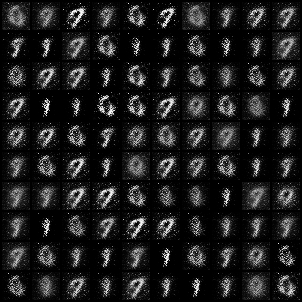

In [23]:
Image('./samples/fake_images-0010.png')


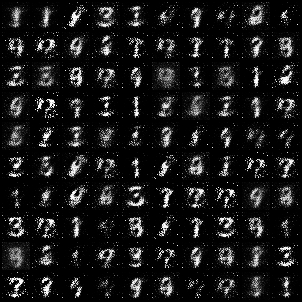

In [24]:
Image('./samples/fake_images-0020.png')


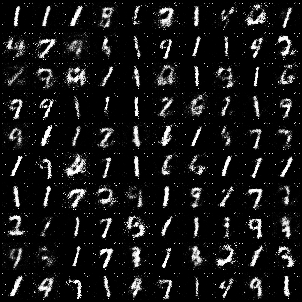

In [25]:
Image('./samples/fake_images-0050.png')


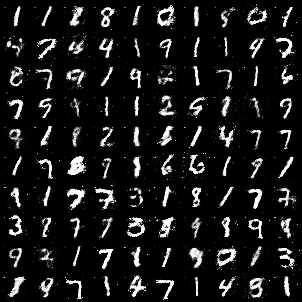

In [26]:
Image('./samples/fake_images-0100.png')


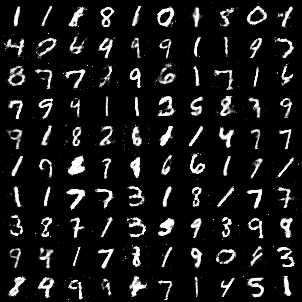

In [27]:
Image('./samples/fake_images-0200.png')


In [28]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/kaggle/working/gans_training.avi

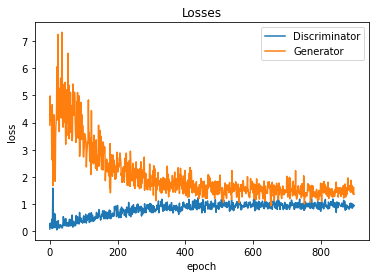

In [29]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

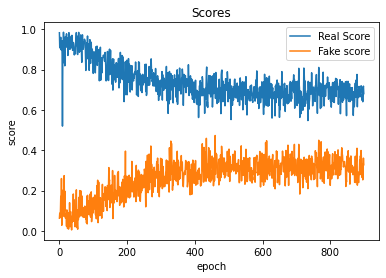

In [30]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');